In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier
import operator

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df = pd.read_excel('../input/patient-data1/VA_Master_File_edited .xlsx', sheet_name='5-yr follow-up only')
print(df.head(5))

/kaggle/input/patient-data1/VA_Master_File_edited .xlsx
   AgeatPlacement Sex              Race  Tooth  Implantlocation  \
0            42.0   M  African American    8.0              3.0   
1            47.0   F  African American    3.0              4.0   
2            47.0   F  African American    4.0              4.0   
3            47.0   F  African American   15.0              4.0   
4            75.0   M         Caucasian   10.0              3.0   

   Implantdiametermm  Implantlengthmm ImplantBrand ImplantREG ImplantLOT  ...  \
0               4.00             13.0           3i     INT413     217618  ...   
1               4.00             13.0    Branemark        NaN     662966  ...   
2               4.00             13.0     Branemak        NaN     651340  ...   
3               3.75             13.0    Branemark        NaN     652281  ...   
4               3.75             13.0    Branemark      28915     661743  ...   

  Clonidine PDE5inhibs  PPIs  SSRIs SNRIs  Bupropion  

In [2]:
# remove columns without a result
df = df[df.Success != ' ']

# Resident and ResidentID repetitive
df.drop(columns = 'Resident', inplace=True)

# The data for women is too low (64) to be relevant in usage so drop those rows
df = df[df.Sex == 'M']

# absence of data means that it did not apply to a certain patient
df.fillna(0, inplace=True)

More in Depth Analysis of Data 

In [3]:
print("The data has {} Rows and {} Columns \n".format(df.shape[0], df.shape[1]))
print("Columns: %s \n" % df.columns)
print("Column Types:\n%s\n" % df.dtypes)

# columns with no set type will have to be cast to a numerical type
print("Columns with no set type: \n%s\n" % df.loc[:, df.dtypes == object].columns)
missing_values = df.isnull().sum()
print("Missing Values: \n%s \n" % missing_values[missing_values >= 50].sort_values(ascending=False))
print("Percentage of data missing: %f percent \n" % (missing_values.sum() / np.product(df.shape) * 100))
print(df.describe())
print("\n")

The data has 864 Rows and 69 Columns 

Columns: Index(['AgeatPlacement', 'Sex', 'Race', 'Tooth', 'Implantlocation',
       'Implantdiametermm', 'Implantlengthmm', 'ImplantBrand', 'ImplantREG',
       'ImplantLOT', 'Attending', 'ResidentID', 'PGYlevel', 'OSorGPRresident',
       'Diabetic', 'diabeticstatus', 'HbA1cplacement3months',
       'Bisphosphonates', 'Immunosuppressed', 'Immunosuppressiveagents',
       'Smoker', 'Illicitdrugs', 'EtOH', 'Keratinizedtissue',
       'Frequencyofhygienevisits', 'Implantcommitteeapproval',
       'Priorbonegrafting', 'Typepriorbonegraft', 'OR2Clinic1', 'Peridexrinse',
       'Preopabx', 'Typelocal', 'amountoflocalccperimplant', 'Flapvsflapless',
       'Immediateimplant', 'Midopxraytaken', 'Drillspeed',
       'Insertionaltorquevalue', 'Graftattimeofplacement',
       'Typeofgraftattimeofplacement', 'Membraneatgraft',
       'Correctionosteotomyplacement', 'STgraftingattimeofplacement',
       'Singleor2stage', 'Periimplantitis', 'Osseointegrationfa

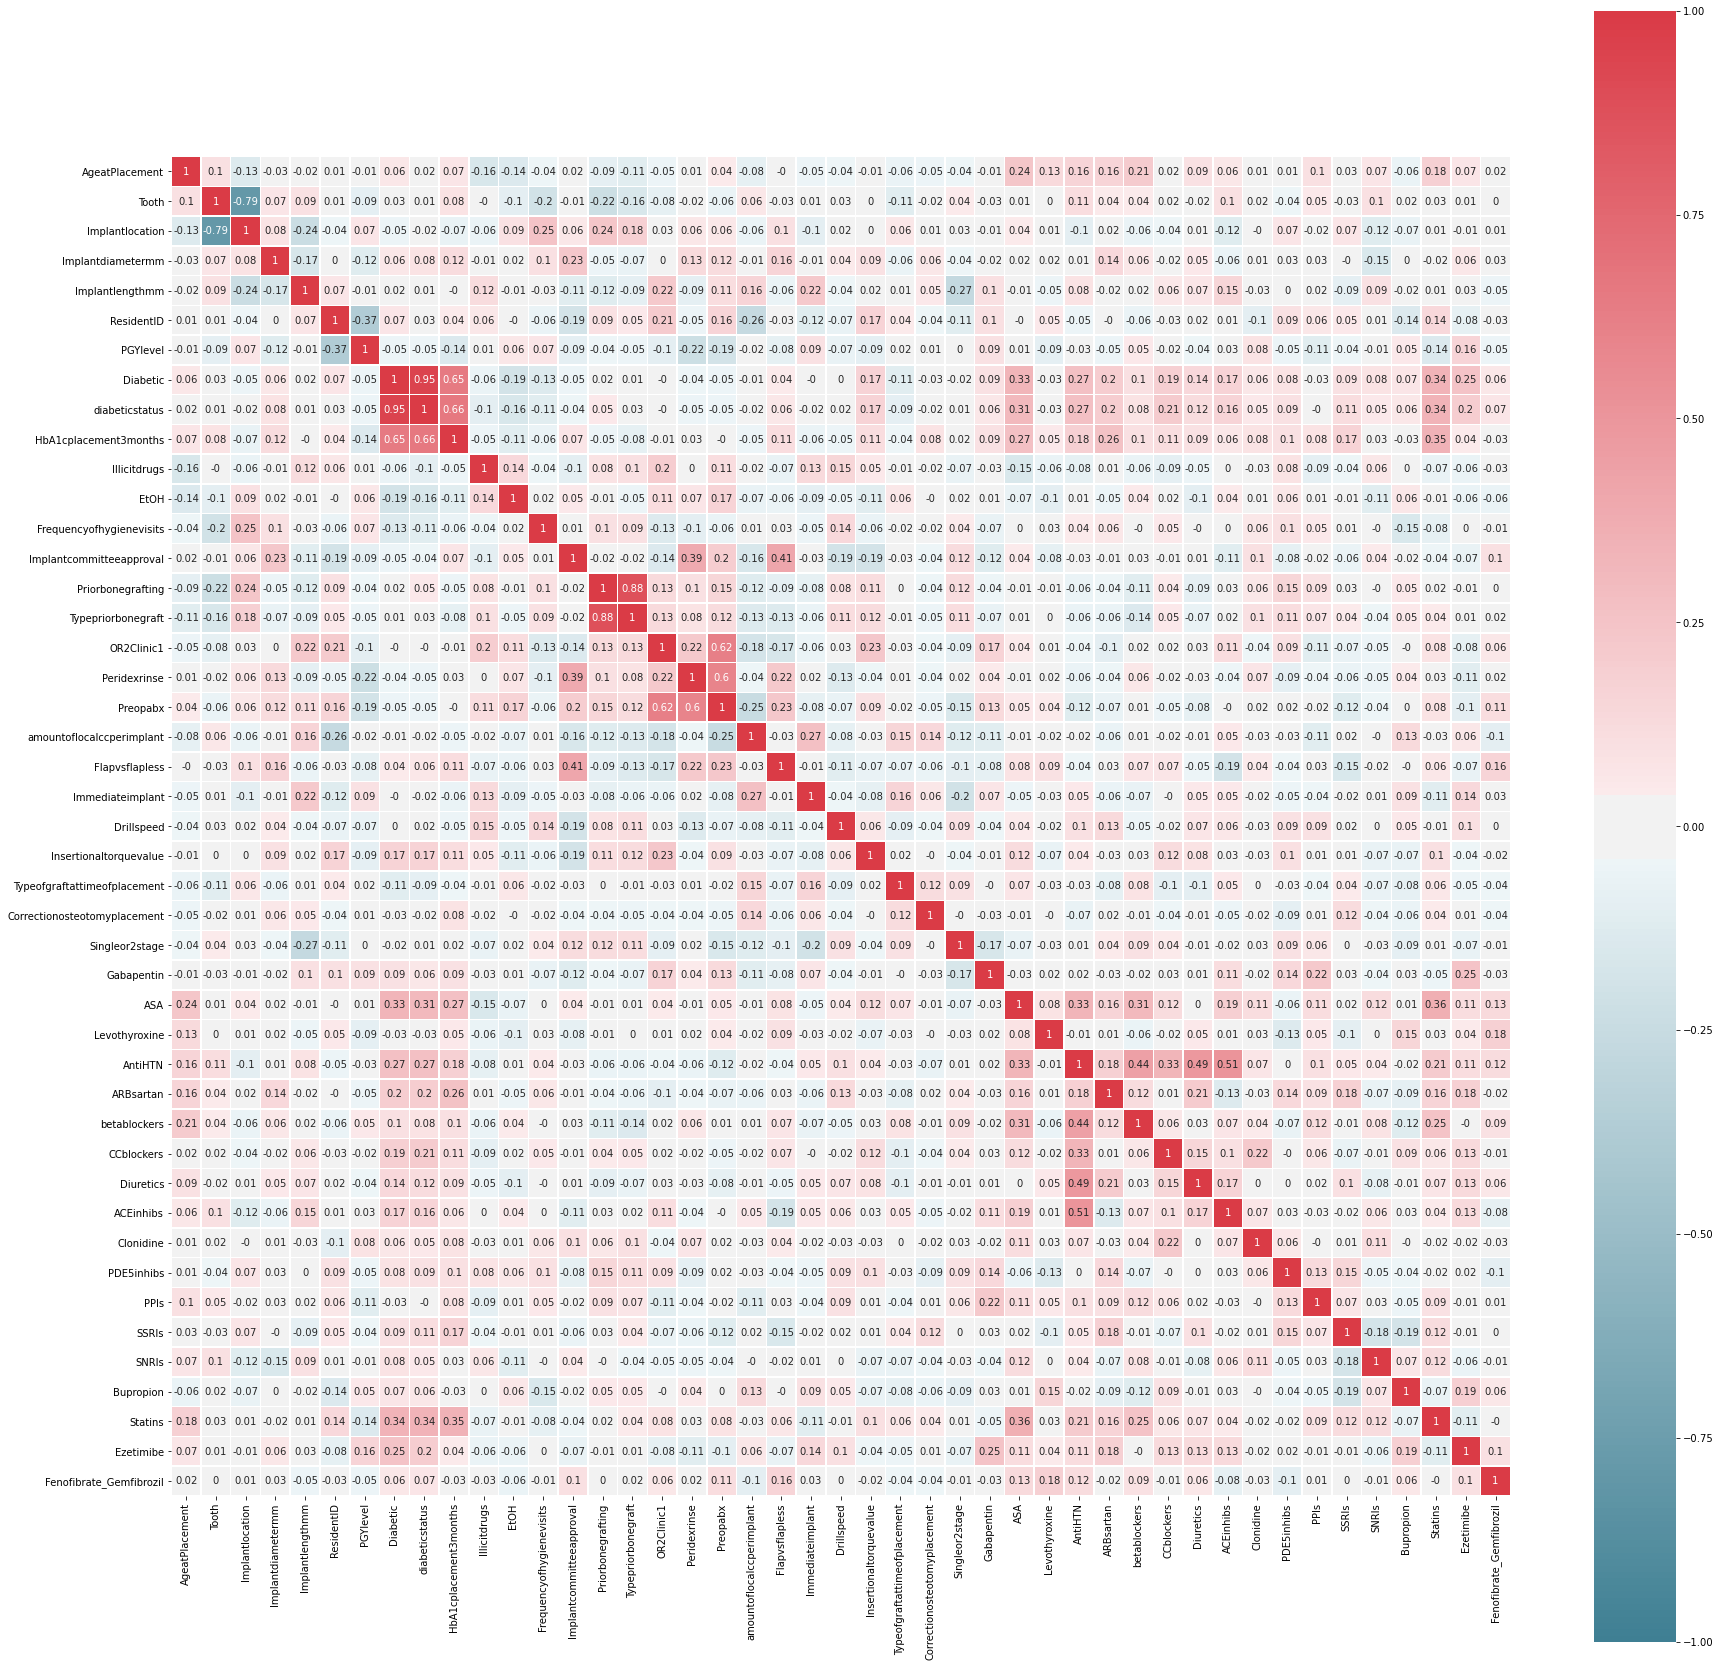

In [4]:
corr = df.corr().round(2)

# Set figure size
f, ax = plt.subplots(figsize=(30, 30))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, annot=True)

In [5]:
# drop super correlated columns

correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)
df.drop(correlated_features, 1, inplace=True)

{'Typepriorbonegraft', 'diabeticstatus'}


In [6]:
cols_to_drop = ['Earlyfailure_less6months', 'Latefailure_greater6months','Success', 
               'Periimplantitis', 'Osseointegrationfailure']

X = df.drop(cols_to_drop, 1)
features = X.columns

# One hot encode only the categorical data
categorical_data = X.loc[:, X.dtypes == object].columns
encoder = ce.one_hot.OneHotEncoder(cols = categorical_data)
encoder.fit(X, verbose=1)

X = encoder.transform(X)
print(X)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


     AgeatPlacement  Sex_1  Race_1  Race_2  Race_3  Race_4  Race_5  Race_6  \
0              42.0      1       1       0       0       0       0       0   
4              75.0      1       0       1       0       0       0       0   
7              57.0      1       1       0       0       0       0       0   
8              57.0      1       1       0       0       0       0       0   
9              57.0      1       1       0       0       0       0       0   
..              ...    ...     ...     ...     ...     ...     ...     ...   
937            55.0      1       0       1       0       0       0       0   
938            52.0      1       1       0       0       0       0       0   
939            57.0      1       0       1       0       0       0       0   
940            57.0      1       0       1       0       0       0       0   
941            70.0      1       1       0       0       0       0       0   

     Race_7  Race_8  ...  MTX_1  MTX_2  MTX_3  MTX_4  MTX_5  MT

In [7]:
# encode dependent variable 
cols = ['Success']
lbl_encoder = LabelEncoder()
for col in cols:
    df[col].replace('yes', 0, inplace=True)
    df[col].replace('no', 1, inplace=True)
    df[col].replace('no ', 1, inplace=True)
    
y = lbl_encoder.fit_transform(df['Success'].astype(str))

In [8]:
# Select 200 most important features
cols = X.columns
X0 = X[cols]
X0 = preprocessing.scale(X0)
X0 = pd.DataFrame(X0, columns=cols)

X_train, X_test, y_train, y_test = train_test_split(X0, y, test_size=0.3)
model = RandomForestClassifier(criterion='gini', max_depth=10, max_features='auto', n_estimators=400)
model.fit(X_train, y_train)
print(len(model.feature_importances_))
feature_imp = pd.Series(model.feature_importances_, index=X0.columns).sort_values(ascending=False)[:200]
cols = feature_imp[:200].index
print(feature_imp[:10])

1025
amountoflocalccperimplant    0.039385
ResidentID                   0.036272
Tooth                        0.033920
Preopabx                     0.027250
HbA1cplacement3months        0.022231
EtOH                         0.020719
AgeatPlacement               0.018691
Implantlocation              0.017410
Implantdiametermm            0.017369
OR2Clinic1                   0.015033
dtype: float64


In [9]:
# pipe = Pipeline([('classifier' , LogisticRegression())])

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1'],
#     'classifier__C' : np.logspace(-1, 1, 10),
#     'classifier__solver' : ['liblinear']}
# ]

# X1 = X[cols]
# X1 = preprocessing.scale(X1)
# X1 = pd.DataFrame(X1, columns = cols)
# X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

# # Create grid search object
# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data
# best_clf = clf.fit(X_train, y_train)
# print(clf.best_params_)

Average Accuracy: 0.827
Average Precision: 0.702
Average Recall: 0.643
Average F1 Score: 0.668
Average AUC Score: 0.77


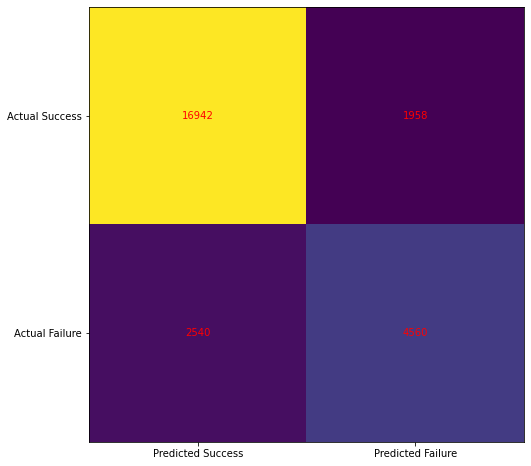

In [10]:
cm = 0
avg_accuracy = 0
avg_precision = 0
avg_recall = 0
avg_f1 = 0
avg_auc = 0
X1 = X[cols]
X1 = preprocessing.scale(X1)
X1 = pd.DataFrame(X1)
num_iters = 100

# run the model multiple times to determine average accuracy, precision, recall, f1
# decrease failure prediction threshold to try to balance false negatives

for i in range(0,num_iters):
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)
    model =  LogisticRegression(C=1.3, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = (y_pred[:,1] >= .4).astype('int')
    cm += confusion_matrix(y_test, y_pred)
    avg_accuracy += metrics.accuracy_score(y_test, y_pred)
    avg_precision += metrics.precision_score(y_test, y_pred)
    avg_recall += metrics.recall_score(y_test, y_pred)
    avg_f1 += metrics.f1_score(y_test, y_pred)
    avg_auc += metrics.roc_auc_score(y_test, y_pred)
    
print("Average Accuracy: {}".format(round(avg_accuracy / num_iters, 3)))
print("Average Precision: {}".format(round(avg_precision / num_iters, 3)))
print("Average Recall: {}".format(round(avg_recall / num_iters, 3)))
print("Average F1 Score: {}".format(round(avg_f1 / num_iters, 3)))
print("Average AUC Score: {}".format(round(avg_auc / num_iters, 3)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Success', 'Predicted Failure'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Success', 'Actual Failure'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

Average Accuracy: 0.839
Average Precision: 0.762
Average Recall: 0.581
Average F1 Score: 0.657
Average AUC Score: 0.757


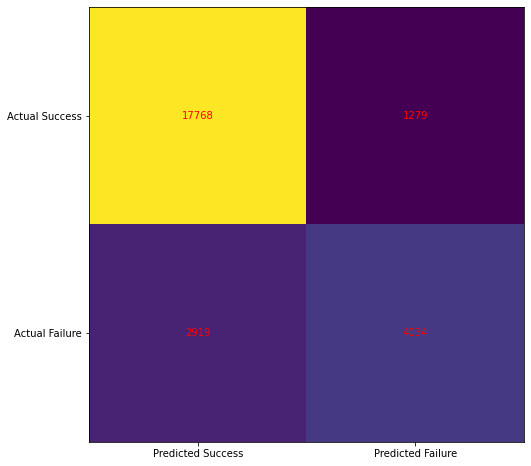

In [11]:
cm = 0
avg_accuracy = 0
avg_precision = 0
avg_recall = 0
avg_f1 = 0
avg_auc = 0
X1 = X[cols]
X1 = preprocessing.scale(X1)
X1 = pd.DataFrame(X1, columns = cols)
num_iters = 100

# run the model multiple times to determine average accuracy, precision, recall, f1
# use bagging to try and increase per

for i in range(0,num_iters):
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)
    clf = LogisticRegression(C=0.167, penalty='l1', solver='liblinear')
    model = BaggingClassifier(clf, n_estimators=400, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = (y_pred[:,1] >= .4).astype('int')
    cm += confusion_matrix(y_test, y_pred)
    avg_accuracy += metrics.accuracy_score(y_test, y_pred)
    avg_precision += metrics.precision_score(y_test, y_pred)
    avg_recall += metrics.recall_score(y_test, y_pred)
    avg_f1 += metrics.f1_score(y_test, y_pred)
    avg_auc += metrics.roc_auc_score(y_test, y_pred)
    
print("Average Accuracy: {}".format(round(avg_accuracy / num_iters, 3)))
print("Average Precision: {}".format(round(avg_precision / num_iters, 3)))
print("Average Recall: {}".format(round(avg_recall / num_iters, 3)))
print("Average F1 Score: {}".format(round(avg_f1 / num_iters, 3)))
print("Average AUC Score: {}".format(round(avg_auc / num_iters, 3)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Success', 'Predicted Failure'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Success', 'Actual Failure'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

**The precision for a Logistic Regression is Good but perhaps it can be improved on by using a Random Forest**
Once again using a gridsearchcv to fine tune the parameters for a random forest

In [12]:
# rfc=RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': list(range(300, 500, 25)),
#     'max_features': ['auto'],
#     'max_depth' : list(range(1, 10)),
#     'min_samples_leaf': list(range(10, 50, 5)),
#     'oob_score' : [True],
#     'criterion' :['gini']
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)
# print(CV_rfc.best_params_)

Average Accuracy: 0.847
Average Precision: 0.797
Average Recall: 0.602
Average F1 Score: 0.684
Average AUC Score: 0.771


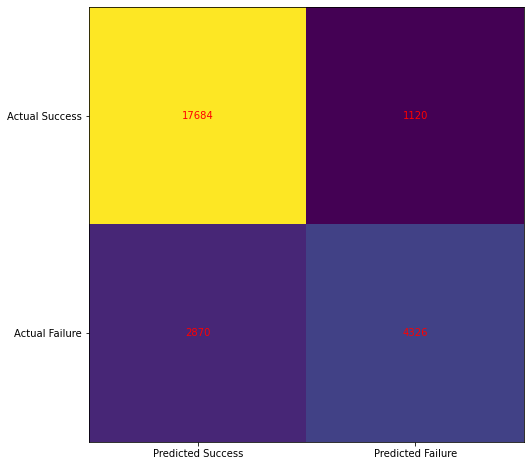

In [13]:
X2 = X[cols]
X2 = preprocessing.scale(X2)
X2 = pd.DataFrame(X2, columns = cols)
cm = 0
avg_accuracy = 0
avg_precision = 0
avg_recall = 0
avg_f1 = 0
avg_auc = 0

num_iters = 100
# run the model multiple times to determine average accuracy, precision, recall
# lower the threshold for the random forest since the model is very prone to false negatives 
# use AdaBoost to further improve predictions

for i in range(0,num_iters):
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3)
    model = RandomForestClassifier(criterion='gini', max_depth=10, max_features='auto', n_estimators=400)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_pred = (y_pred[:,1] >= .35).astype('int')
    cm += confusion_matrix(y_test, y_pred)
    avg_accuracy += metrics.accuracy_score(y_test, y_pred)
    avg_precision += metrics.precision_score(y_test, y_pred)
    avg_recall += metrics.recall_score(y_test, y_pred)
    avg_f1 += metrics.f1_score(y_test, y_pred)
    avg_auc += metrics.roc_auc_score(y_test, y_pred)

print("Average Accuracy: {}".format(round(avg_accuracy / num_iters, 3)))
print("Average Precision: {}".format(round(avg_precision / num_iters, 3)))
print("Average Recall: {}".format(round(avg_recall / num_iters, 3)))
print("Average F1 Score: {}".format(round(avg_f1 / num_iters, 3)))
print("Average AUC Score: {}".format(round(avg_auc / num_iters, 3)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Success', 'Predicted Failure'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Success', 'Actual Failure'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

**As you can see this model predicts success much more than it predicts failure and thus the false negative rate is much higher than it should be. Comparing the random forest to the logistic model the logistic model is probably better because it can predict failure much better than the random forestt**

In [14]:
# X3 = X[cols]
# X3 = preprocessing.scale(X3)
# X3 = pd.DataFrame(X3, columns = cols)
# X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.3)

# Cs = np.linspace(.001, 1, 5)
# gammas = np.linspace(.001, .5, 10)
# kernels = ['rbf', 'sigmoid', 'linear']
# param_grid = {'C': Cs, 'gamma' : gammas, 'kernel':kernels, 'class_weight': ['balanced']}
# grid_search = GridSearchCV(SVC(), param_grid, cv=3)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_
# print(grid_search.best_params_)

Average Accuracy: 0.87
Average Precision: 0.86
Average Recall: 0.622
Average F1 Score: 0.72
Average AUC Score: 0.792


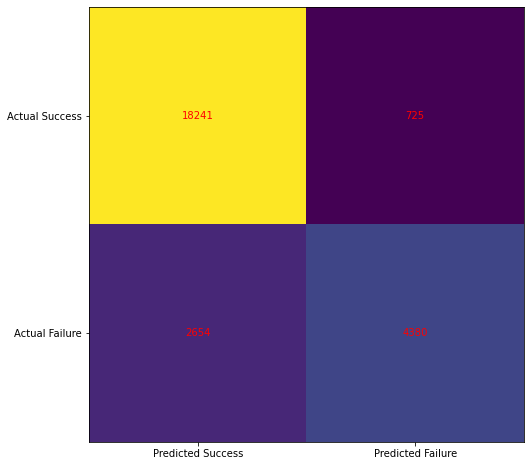

In [15]:
X3 = X[cols]
X3 = preprocessing.scale(X3)
X3 = pd.DataFrame(X2, columns = cols)
cm = 0
avg_accuracy = 0
avg_precision = 0
avg_recall = 0
avg_f1 = 0
avg_auc = 0

num_iters = 100
# run the model multiple times to determine average accuracy, precision, recall
# balance the class weights since the model is very prone to false negatives 

for i in range(0,num_iters):
    X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.3)
    clf = SVC(kernel='rbf', class_weight='balanced', gamma=.001, C=1)
    model = BaggingClassifier(base_estimator=clf, n_estimators=300, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm += confusion_matrix(y_test, y_pred)
    avg_accuracy += metrics.accuracy_score(y_test, y_pred)
    avg_precision += metrics.precision_score(y_test, y_pred)
    avg_recall += metrics.recall_score(y_test, y_pred)
    avg_f1 += metrics.f1_score(y_test, y_pred)
    avg_auc += metrics.roc_auc_score(y_test, y_pred)

print("Average Accuracy: {}".format(round(avg_accuracy / num_iters, 3)))
print("Average Precision: {}".format(round(avg_precision / num_iters, 3)))
print("Average Recall: {}".format(round(avg_recall / num_iters, 3)))
print("Average F1 Score: {}".format(round(avg_f1 / num_iters, 3)))
print("Average AUC Score: {}".format(round(avg_auc / num_iters, 3)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Success', 'Predicted Failure'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Success', 'Actual Failure'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [16]:
# # Pipeline to determine best parameters for the XGBC

# pipe = Pipeline([('classifier' , XGBClassifier())])

# param_grid = [
#     {'classifier' : [XGBClassifier()],
#     'classifier__learning_rate' : np.linspace(0, 1, 4), 
#     'classifier__max_depth' : list(range(1, 3)),
#     'classifier__n_estimators': [400],
#     'classifier__gamma' : np.linspace(0, 1, 4)}                     
# ]

# X1 = X[X.columns]
# X1 = preprocessing.scale(X1)
# X1 = pd.DataFrame(X1, columns = X.columns)
# X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

# # Create grid search object
# clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data
# best_clf = clf.fit(X_train, y_train)
# print(clf.best_params_)

Average Accuracy: 0.842
Average Precision: 0.747
Average Recall: 0.642
Average F1 Score: 0.688
Average AUC Score: 0.78


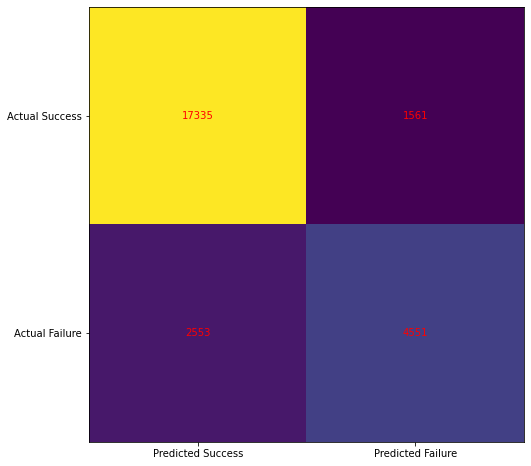

In [17]:
X4 = X[cols]
X4 = preprocessing.scale(X4)
X4 = pd.DataFrame(X4, columns = cols)
cm = 0
avg_accuracy = 0
avg_precision = 0
avg_recall = 0
avg_f1 = 0
avg_auc = 0

num_iters = 100
# run the model multiple times to determine average accuracy, precision, recall
# lower the threshold for the random forest since the model is very prone to false negatives 
# use AdaBoost to further improve predictions

for i in range(0,num_iters):
    X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.3)
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm += confusion_matrix(y_test, y_pred)
    avg_accuracy += metrics.accuracy_score(y_test, y_pred)
    avg_precision += metrics.precision_score(y_test, y_pred)
    avg_recall += metrics.recall_score(y_test, y_pred)
    avg_f1 += metrics.f1_score(y_test, y_pred)
    avg_auc += metrics.roc_auc_score(y_test, y_pred)

print("Average Accuracy: {}".format(round(avg_accuracy / num_iters, 3)))
print("Average Precision: {}".format(round(avg_precision / num_iters, 3)))
print("Average Recall: {}".format(round(avg_recall / num_iters, 3)))
print("Average F1 Score: {}".format(round(avg_f1 / num_iters, 3)))
print("Average AUC Score: {}".format(round(avg_auc / num_iters, 3)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Success', 'Predicted Failure'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Success', 'Actual Failure'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()